# Serving your model exercise. Part 1 - Flask

## Intro
Reminder, there will usually be 3 different places where the code relevant to our model prediction runs:
1. **Training computer / server** - where we train our model and save it
2. **Inference server** - server that listens to REST API requests to make predictions / inferences with the model that was trained on the model server. Potentially, we could have many such servers. 
3. **Client** - client application (browser, mobile app etc.) that needs a prediction, and requests from **inference server** over HTTP with REST API to make the prediction

## 1. Getting to a trained model
- Choose one of the models you trained in one the previous exercises or any other model. **Do not take something from many Flask examples online!**

In [7]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import math
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV


In [8]:
df = pd.read_csv(r'dataset_cars.csv')
df.sample(8)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
831,Tata Nano Lx,2011,120000.0,20000.0,Petrol,Individual,Manual,First Owner
2305,Maruti Celerio ZXI MT BSIV,2019,425000.0,3700.0,Petrol,Individual,Manual,First Owner
303,Chevrolet Sail 1.2 LT ABS,2014,350000.0,30000.0,Petrol,Individual,Manual,First Owner
1518,Maruti Wagon R VXI,2014,315000.0,41000.0,Petrol,Dealer,Manual,First Owner
338,Maruti Swift Dzire VDI,2015,490000.0,60000.0,Diesel,Individual,Manual,Second Owner
2110,Hyundai i10 Sportz 1.2,2010,210000.0,60000.0,Petrol,Individual,Manual,Second Owner
644,Tata Hexa XT 4X4,2017,1600000.0,3000.0,Diesel,Individual,Manual,First Owner
3121,Volkswagen Polo 1.2 MPI Highline,2014,425000.0,40000.0,Petrol,Individual,Manual,First Owner


- Specify where can one download the dataset from (to be used during checking the exercise)

Attached

- Say in one word what is the business problem and what you are predicting 

Price

- Preprocess, split to train and test dataset

In [9]:
df.shape

(4340, 8)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           4340 non-null   object 
 1   year           4340 non-null   int64  
 2   selling_price  4339 non-null   float64
 3   km_driven      4336 non-null   float64
 4   fuel           4337 non-null   object 
 5   seller_type    4340 non-null   object 
 6   transmission   4340 non-null   object 
 7   owner          4340 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 271.4+ KB


In [11]:
df.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,year,selling_price,km_driven
count,4340,4339,4336
mean,2013.09,504090,66222
std,4.21534,578610,46661.1
min,1992,20000,1
25%,2011,207500,35000
50%,2014,350000,60000
75%,2016,600000,90000
max,2020,8.9e+06,806599


**Number of unique values for each feature:**

In [12]:
pd.DataFrame(df.apply((lambda x: x.value_counts().count())), columns=['num_of_unique_values'])

,num_of_unique_values
name,1491
year,27
selling_price,445
km_driven,770
fuel,5
seller_type,5
transmission,2
owner,9


**Missing values:**

In [13]:
pd.DataFrame(df.isna().sum()[(df.isna().sum())>0], columns=['Missing_Count'])

,Missing_Count
selling_price,1
km_driven,4
fuel,3


dropping duplicates:

In [14]:
df = df.drop_duplicates()

Check that all the SalePrice is not null, and delete the rows if the value is null:

In [15]:
df.shape

(3582, 8)

In [16]:
df = df.dropna(axis=0)

In [17]:
df.shape

(3574, 8)

merging values of an individual and values of a seller:

In [18]:
df['seller_type'].replace(['Indi','Indi.'], 'Individual', inplace = True)
df['seller_type'].replace(['Trustmark Dealer'], 'Dealer', inplace = True)

df.seller_type.value_counts()

Individual    2831
Dealer         743
Name: seller_type, dtype: int64

In [19]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000.0,70000.0,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000.0,50000.0,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000.0,100000.0,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000.0,46000.0,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000.0,141000.0,Diesel,Individual,Manual,Second Owner


In [20]:
df['owner'].replace({
        "First Owner": 1,
        "Second Owner": 2,
        "Third Owner": 3,
        "Fourth Owner": 4,
        "Fifth Owner": 4,
        "Sixth Owner": 4,
        "Seventh Owner": 4,
        "Eighth Owner": 4,
        "Test Drive Car": 0},
        inplace=True)

In [21]:
df['owner'].value_counts()

1    2214
2     976
3     289
4      78
0      17
Name: owner, dtype: int64

In [22]:
df['fuel'].replace({
    "CNG": 'Other',
    "LPG": 'Other',
    "Electric": 'Other'
},
                   inplace=True)

grouping cars by manufacturer

In [23]:
df.name = df['name'].apply(lambda x: x.split()[0])

merging manufacturers with less than 1 percent into 'Other'

In [24]:
rares = df['name'].value_counts()[-17:].index
for rare in rares:
    df.name.replace(rare, 'Other', inplace=True)

merging years before 2003 (all contain less than 1 percent) into 2003

In [25]:
rares = df['year'].value_counts()[-10:].index
for rare in rares:
    df.year.replace(rare, 2003, inplace=True)

In [26]:
def plot_continuous_dist(data, feature, color):
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.2, .8)}, 
                                        figsize=(16,9))
    ax_box.set(title=f"\n{feature} distribution")
    sns.boxplot(data[feature], ax=ax_box, color=color)
    sns.distplot(data[feature], ax=ax_hist, color=color)
    ax_box.set(xlabel='')
    plt.tight_layout()
    plt.show()

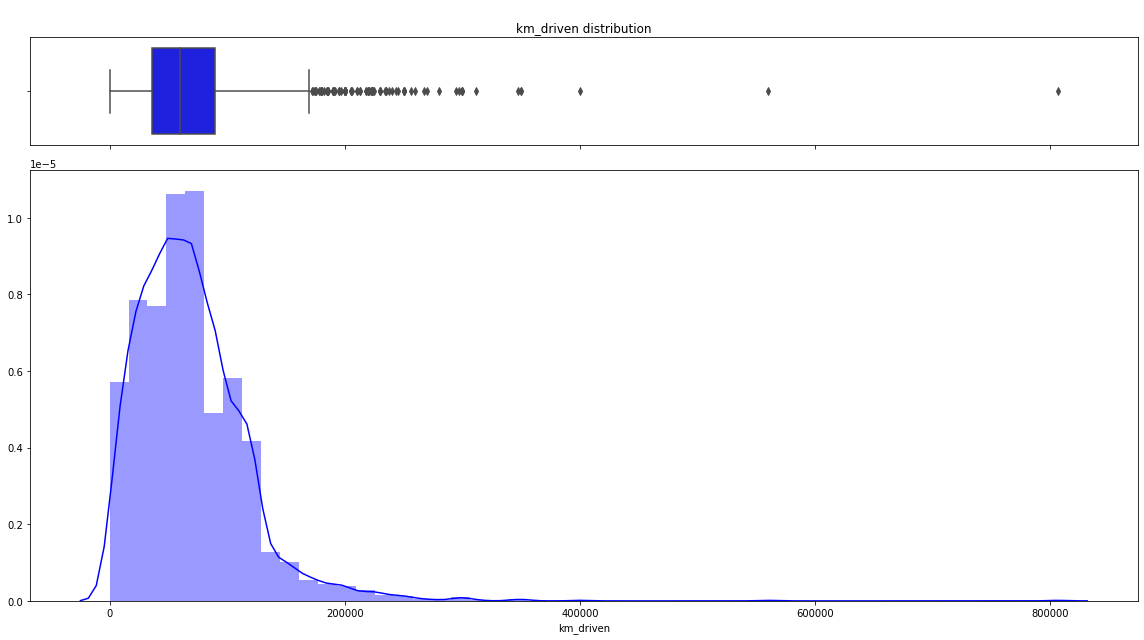

In [27]:
plot_continuous_dist(df, 'km_driven', 'blue')

cutting outliers, check how many values are above 300K

In [28]:
(df['km_driven']>=300000).sum()

11

In [29]:
df = df[df['km_driven']<300000]

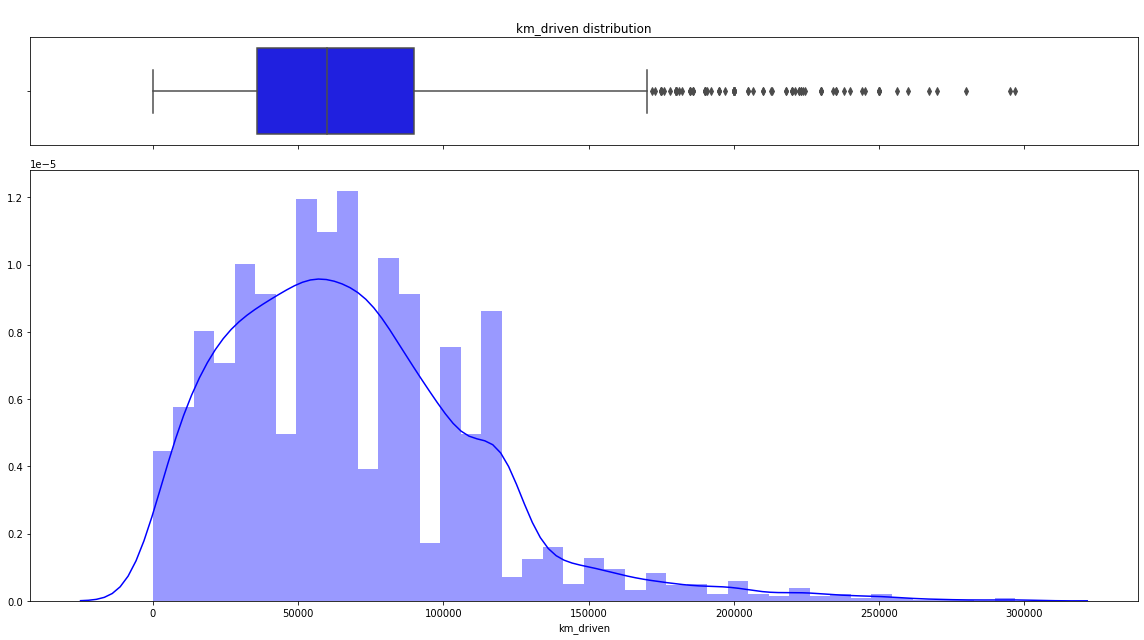

In [30]:
plot_continuous_dist(df, 'km_driven', 'blue')

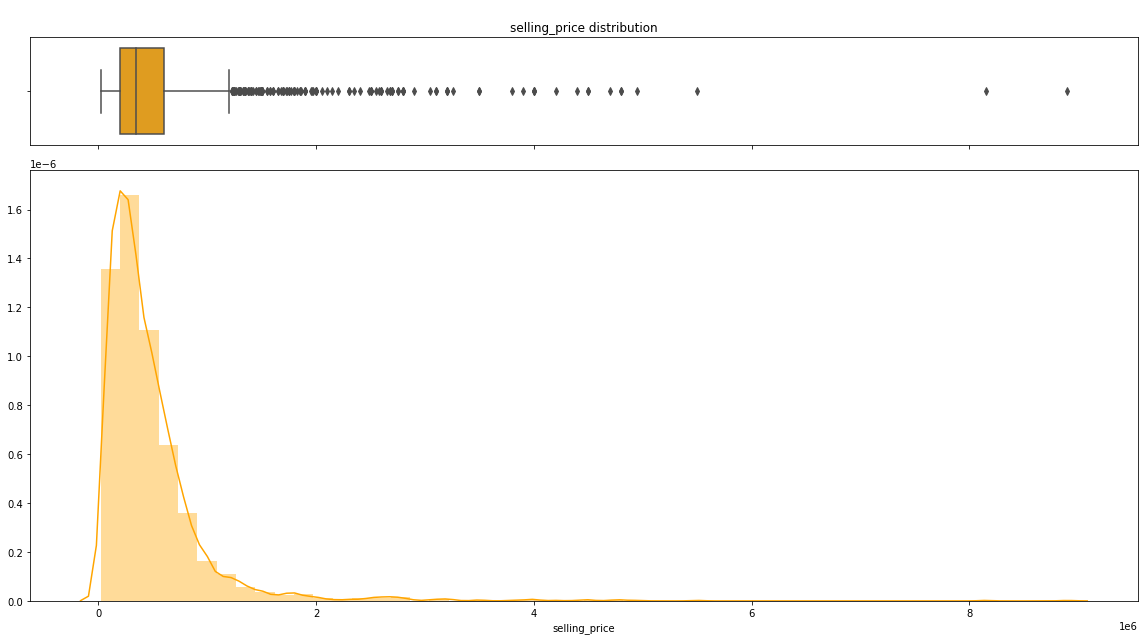

In [31]:
plot_continuous_dist(df, 'selling_price', 'orange')

In [32]:
df.shape

(3563, 8)

In [33]:
for feat in df.columns:
    print("\n\n", df[feat].value_counts())



 Maruti        1070
Hyundai        636
Mahindra       328
Tata           306
Ford           221
Honda          214
Other          171
Toyota         165
Chevrolet      150
Renault        109
Volkswagen      92
Nissan          52
Skoda           49
Name: name, dtype: int64


 2017    346
2012    338
2015    332
2014    319
2013    297
2018    295
2016    280
2011    246
2010    206
2009    168
2019    162
2008    129
2007    117
2003     94
2006     90
2005     61
2020     45
2004     38
Name: year, dtype: int64


 300000.0    137
250000.0    111
350000.0    104
500000.0     87
600000.0     84
           ... 
173000.0      1
48000.0       1
641000.0      1
193000.0      1
256000.0      1
Name: selling_price, Length: 444, dtype: int64


 70000.0     211
120000.0    199
80000.0     199
60000.0     194
50000.0     180
           ... 
270000.0      1
44800.0       1
4500.0        1
92686.0       1
41723.0       1
Name: km_driven, Length: 763, dtype: int64


 Diesel    1791
Petrol    1712


In [34]:
df = pd.get_dummies(df)
df.shape

(3563, 24)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3563 entries, 0 to 4339
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   year                    3563 non-null   int64  
 1   selling_price           3563 non-null   float64
 2   km_driven               3563 non-null   float64
 3   owner                   3563 non-null   int64  
 4   name_Chevrolet          3563 non-null   uint8  
 5   name_Ford               3563 non-null   uint8  
 6   name_Honda              3563 non-null   uint8  
 7   name_Hyundai            3563 non-null   uint8  
 8   name_Mahindra           3563 non-null   uint8  
 9   name_Maruti             3563 non-null   uint8  
 10  name_Nissan             3563 non-null   uint8  
 11  name_Other              3563 non-null   uint8  
 12  name_Renault            3563 non-null   uint8  
 13  name_Skoda              3563 non-null   uint8  
 14  name_Tata               3563 non-null   

In [36]:
X = df.drop('selling_price', axis=1)
y = df['selling_price']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

- Train the model - the exact accuracy is not of big importance here

Random Forest Regressor

In [38]:
params = {'min_samples_split':[2,4,6],'max_depth':[3,5,8,13,21]}
rf_regressor = GridSearchCV(RandomForestRegressor(), params)

In [39]:
rf_regressor.fit(X_train, y_train)
rf_regressor.best_params_

{'max_depth': 8, 'min_samples_split': 4}

In [40]:
rf = RandomForestRegressor(max_depth=8, min_samples_split=2)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

- Do a few predictions of the model locally

In [41]:
rmsd_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
rmsd_rf

243800.00138012745

In [42]:
r2_score(y_test, y_pred_rf)

0.7747426492874683

In [43]:
y_test

2696     800000.0
205      425000.0
3287    1600000.0
1529     250000.0
3438     570000.0
          ...    
739      229999.0
494      310000.0
3822     125000.0
1185     610000.0
1666     368000.0
Name: selling_price, Length: 713, dtype: float64

This code will run on the **training server**

## 2. Save you model, predict with saved model

Simulate in this notebook code that will happen during training on the **training server**:
- Using `pickle`, save your model to disk. Reference: https://scikit-learn.org/stable/modules/model_persistence.html

In [44]:
import pickle

In [45]:
filename = 'finalized_model.pickle'
pickle.dump(rf, open(filename, 'wb'))

- Save the test dataset to file.  What's a good format(s) for saving datasets?

In [46]:
test_set = pd.concat([X_test, y_test], axis=1) 

In [47]:
test_set.to_pickle('my_test_set.pickle')

Simulate in this notebook code that will happen during inference on the **inference server**:
- Load the model again with `pickle`.

In [48]:
# load the model from disk
loaded_model = pickle.load(open('finalized_model.pickle', 'rb'))

- Read the test dataset file, and perform some predictions
- Compare the predictions received before saving the model, and after reading a saved model.  Show that you get the same results. 

In [49]:
loaded_data = pickle.load(open('my_test_set.pickle', 'rb'))
loaded_y_test = loaded_data['selling_price']
loaded_X_test = loaded_data.drop('selling_price', axis=1)

In [50]:
loaded_model.score(loaded_X_test, loaded_y_test)

0.7747426492874683

Amazing!!! we got the same prediction as we received before

## 3. Serve your model

Now we are done with **training server**, since we have the saved model.  From now all that's relevant is **inference server** and **client** code.

Let's create the **inference server** that answers to REST APIs with predictions:

- Using `flask`, create a Pycharm project and implement the following prediction API:
- **Single prediction API** that receives inputs as parameters (no body), and returns a single prediction as a string / text.  
- Example: http://localhost:5000/predict_single?key1=value1&key2=value2 (replace `key1`, `value1` etc. names with your relevant feature names and values)
- Consider what's the best place in your code to put the code that reads from the model.  Why?
- In general, take runtime efficiency into account.  Your API might be called large number of times per second, and you will be paying for more inference servers if your code is not efficient.
- Copy your **inference server** code also here for reference

from flask import Flask\
from flask import request\
import pickle\

app = Flask(__name__)\


@app.route('/predict_single')\
def predict_single():\
    year = int(request.args.get('year'))\
    km_driven = int(request.args.get('km_driven'))\
    owner = int(request.args.get('owner'))\
    name_Chevrolet = int(request.args.get('name_Chevrolet'))\
    name_Ford = int(request.args.get('name_Ford'))\
    name_Honda = int(request.args.get('name_Honda'))\
    name_Hyundai = int(request.args.get('name_Hyundai'))\
    name_Mahindra = int(request.args.get('name_Mahindra'))\
    name_Maruti = int(request.args.get('name_Maruti'))\
    name_Nissan = int(request.args.get('name_Nissan'))\
    name_Other = int(request.args.get('name_Other'))\
    name_Renault = int(request.args.get('name_Renault'))\
    name_Skoda = int(request.args.get('name_Skoda'))\
    name_Tata = int(request.args.get('name_Tata'))\
    name_Toyota = int(request.args.get('name_Toyota'))\
    name_Volkswagen = int(request.args.get('name_Volkswagen'))\
    fuel_Diesel = int(request.args.get('fuel_Diesel'))\
    fuel_Other = int(request.args.get('fuel_Other'))\
    fuel_Petrol = int(request.args.get('fuel_Petrol'))\
    seller_type_Dealer = int(request.args.get('seller_type_Dealer'))\
    seller_type_Individual = int(request.args.get('seller_type_Individual'))\
    transmission_Automatic = int(request.args.get('transmission_Automatic'))\
    transmission_Manual = int(request.args.get('transmission_Manual'))\

    # load model from file
    loaded_model = pickle.load(open('finalized_model.pickle', 'rb'))
    names = [year, km_driven, owner, name_Chevrolet, name_Ford,
             name_Honda, name_Hyundai, name_Mahindra, name_Maruti,
             name_Nissan, name_Other, name_Renault, name_Skoda, name_Tata,
             name_Toyota, name_Volkswagen, fuel_Diesel, fuel_Other,
             fuel_Petrol, seller_type_Dealer, seller_type_Individual,
             transmission_Automatic, transmission_Manual]
    y_pred = loaded_model.predict([names])
    return str(y_pred)[0]



if __name__ == '__main__':\
    app.run(debug=True)

## 4. Consume your model with python

Use Python `requests` module from here to make a prediction.  **Print input and output of the prediction.**

**Warning**: don't get used to seeing it in a Jupyter notebook.  This code will usually run inside a **client application**

In [51]:
import requests

payload =     {
        "year": 2012,
        "km_driven": 180000,
        "owner": 1,
        "name_Chevrolet": 0,
        "name_Ford": 0,
        "name_Honda": 0,
        "name_Hyundai": 0,
        "name_Mahindra": 0,
        "name_Maruti": 0,
        "name_Nissan": 0,
        "name_Other": 0,
        "name_Renault": 0,
        "name_Skoda": 0,
        "name_Tata": 0,
        "name_Toyota": 1,
        "name_Volkswagen": 0,
        "fuel_Diesel": 1,
        "fuel_Other": 0,
        "fuel_Petrol": 0,
        "seller_type_Dealer": 0,
        "seller_type_Individual": 1,
        "transmission_Automatic": 0,
        "transmission_Manual": 1
    }

url = 'http://127.0.0.1:5000/predict_single'
res = requests.get(url, params=payload).text
print(f'URL - \n{url}\n')
print(res)

URL - 
http://127.0.0.1:5000/predict_single

523530.2332754636


## 5. Using JSON files

- Using `flask`, add code to your previous file in Pycharm **with inference code** to create the following prediction API (in addition to **Single prediction API** done above):
- **Multiple prediction API** that receives input many observations to predict on as a json file in the body, and returns a json file with predictions.
- Your **JSON** file format has to be efficient, clear and following JSON file syntax: 
  - JSON file is a nested structure of potentially multiple dictionaries and lists 
  - JSON file tip: Use lists, every member in the list can be a dictionary of all the features.  
  - JSON file tip: Do not put indexes of predictions into the JSON files, indexes of predictions can be easily computed with Python code later 
  - JSON files are sometimes slightly verbose, but are extremely human readable.  Just looking at your JSON files of input and output, is it possible to understand what were the observations in input and what were the predictions in output?
  - See https://www.json.org/json-en.html for JSON format
- Think about efficiency of your code - your REST API might be called a huge number of times, with a huge number of observations every time.  Can part of the code be done only once?  Can you predict on everything together? Can you do less or cheaper data conversions?
- Example of URL that will be used to predict: http://localhost:5000/predict
- Reference for working with JSONs in Flask: https://pythonise.com/series/learning-flask/working-with-json-in-flask
- Do you need a GET or a POST type of REST API call? Does it change what you did in step 3?  Conceptually, would you say it makes sense to use GET or POST types for predictions?
- Copy your **inference server** code also here for reference 

In [52]:
# JSON POSTED - 
# [
#     {
#         "year": 2012.0,
#         "km_driven": 180000.0,
#         "owner": 1.0,
#         "name_Chevrolet": 0.0,
#         "name_Ford": 0.0,
#         "name_Honda": 0.0,
#         "name_Hyundai": 0.0,
#         "name_Mahindra": 0.0,
#         "name_Maruti": 0.0,
#         "name_Nissan": 0.0,
#         "name_Other": 0.0,
#         "name_Renault": 0.0,
#         "name_Skoda": 0.0,
#         "name_Tata": 0.0,
#         "name_Toyota": 1.0,
#         "name_Volkswagen": 0.0,
#         "fuel_Diesel": 1.0,
#         "fuel_Other": 0.0,
#         "fuel_Petrol": 0.0,
#         "seller_type_Dealer": 0.0,
#         "seller_type_Individual": 1.0,
#         "transmission_Automatic": 0.0,
#         "transmission_Manual": 1.0
#     },
#     {
#         "year": 2013.0,
#         "km_driven": 20000.0,
#         "owner": 1.0,
#         "name_Chevrolet": 1.0,
#         "name_Ford": 0.0,
#         "name_Honda": 0.0,
#         "name_Hyundai": 0.0,
#         "name_Mahindra": 0.0,
#         "name_Maruti": 0.0,
#         "name_Nissan": 0.0,
#         "name_Other": 0.0,
#         "name_Renault": 0.0,
#         "name_Skoda": 0.0,
#         "name_Tata": 0.0,
#         "name_Toyota": 0.0,
#         "name_Volkswagen": 0.0,
#         "fuel_Diesel": 1.0,
#         "fuel_Other": 0.0,
#         "fuel_Petrol": 0.0,
#         "seller_type_Dealer": 1.0,
#         "seller_type_Individual": 0.0,
#         "transmission_Automatic": 0.0,
#         "transmission_Manual": 1.0
#     },
#     {
#         "year": 2018.0,
#         "km_driven": 40000.0,
#         "owner": 1.0,
#         "name_Chevrolet": 0.0,
#         "name_Ford": 0.0,
#         "name_Honda": 0.0,
#         "name_Hyundai": 1.0,
#         "name_Mahindra": 0.0,
#         "name_Maruti": 0.0,
#         "name_Nissan": 0.0,
#         "name_Other": 0.0,
#         "name_Renault": 0.0,
#         "name_Skoda": 0.0,
#         "name_Tata": 0.0,
#         "name_Toyota": 0.0,
#         "name_Volkswagen": 0.0,
#         "fuel_Diesel": 1.0,
#         "fuel_Other": 0.0,
#         "fuel_Petrol": 0.0,
#         "seller_type_Dealer": 0.0,
#         "seller_type_Individual": 1.0,
#         "transmission_Automatic": 1.0,
#         "transmission_Manual": 0.0
#     },
#     {
#         "year": 2009.0,
#         "km_driven": 48000.0,
#         "owner": 1.0,
#         "name_Chevrolet": 1.0,
#         "name_Ford": 0.0,
#         "name_Honda": 0.0,
#         "name_Hyundai": 0.0,
#         "name_Mahindra": 0.0,
#         "name_Maruti": 0.0,
#         "name_Nissan": 0.0,
#         "name_Other": 0.0,
#         "name_Renault": 0.0,
#         "name_Skoda": 0.0,
#         "name_Tata": 0.0,
#         "name_Toyota": 0.0,
#         "name_Volkswagen": 0.0,
#         "fuel_Diesel": 0.0,
#         "fuel_Other": 0.0,
#         "fuel_Petrol": 1.0,
#         "seller_type_Dealer": 0.0,
#         "seller_type_Individual": 1.0,
#         "transmission_Automatic": 0.0,
#         "transmission_Manual": 1.0
#     },
#     {
#         "year": 2017.0,
#         "km_driven": 44077.0,
#         "owner": 1.0,
#         "name_Chevrolet": 0.0,
#         "name_Ford": 1.0,
#         "name_Honda": 0.0,
#         "name_Hyundai": 0.0,
#         "name_Mahindra": 0.0,
#         "name_Maruti": 0.0,
#         "name_Nissan": 0.0,
#         "name_Other": 0.0,
#         "name_Renault": 0.0,
#         "name_Skoda": 0.0,
#         "name_Tata": 0.0,
#         "name_Toyota": 0.0,
#         "name_Volkswagen": 0.0,
#         "fuel_Diesel": 0.0,
#         "fuel_Other": 0.0,
#         "fuel_Petrol": 1.0,
#         "seller_type_Dealer": 1.0,
#         "seller_type_Individual": 0.0,
#         "transmission_Automatic": 1.0,
#         "transmission_Manual": 0.0
#     },
#     {
#         "year": 2017.0,
#         "km_driven": 50000.0,
#         "owner": 1.0,
#         "name_Chevrolet": 0.0,
#         "name_Ford": 0.0,
#         "name_Honda": 0.0,
#         "name_Hyundai": 0.0,
#         "name_Mahindra": 0.0,
#         "name_Maruti": 0.0,
#         "name_Nissan": 0.0,
#         "name_Other": 0.0,
#         "name_Renault": 0.0,
#         "name_Skoda": 0.0,
#         "name_Tata": 1.0,
#         "name_Toyota": 0.0,
#         "name_Volkswagen": 0.0,
#         "fuel_Diesel": 1.0,
#         "fuel_Other": 0.0,
#         "fuel_Petrol": 0.0,
#         "seller_type_Dealer": 0.0,
#         "seller_type_Individual": 1.0,
#         "transmission_Automatic": 1.0,
#         "transmission_Manual": 0.0
#     },
#     {
#         "year": 2008.0,
#         "km_driven": 60000.0,
#         "owner": 2.0,
#         "name_Chevrolet": 0.0,
#         "name_Ford": 0.0,
#         "name_Honda": 0.0,
#         "name_Hyundai": 0.0,
#         "name_Mahindra": 0.0,
#         "name_Maruti": 1.0,
#         "name_Nissan": 0.0,
#         "name_Other": 0.0,
#         "name_Renault": 0.0,
#         "name_Skoda": 0.0,
#         "name_Tata": 0.0,
#         "name_Toyota": 0.0,
#         "name_Volkswagen": 0.0,
#         "fuel_Diesel": 0.0,
#         "fuel_Other": 0.0,
#         "fuel_Petrol": 1.0,
#         "seller_type_Dealer": 0.0,
#         "seller_type_Individual": 1.0,
#         "transmission_Automatic": 0.0,
#         "transmission_Manual": 1.0
#     },
#     {
#         "year": 2012.0,
#         "km_driven": 110000.0,
#         "owner": 3.0,
#         "name_Chevrolet": 0.0,
#         "name_Ford": 0.0,
#         "name_Honda": 0.0,
#         "name_Hyundai": 1.0,
#         "name_Mahindra": 0.0,
#         "name_Maruti": 0.0,
#         "name_Nissan": 0.0,
#         "name_Other": 0.0,
#         "name_Renault": 0.0,
#         "name_Skoda": 0.0,
#         "name_Tata": 0.0,
#         "name_Toyota": 0.0,
#         "name_Volkswagen": 0.0,
#         "fuel_Diesel": 0.0,
#         "fuel_Other": 0.0,
#         "fuel_Petrol": 1.0,
#         "seller_type_Dealer": 0.0,
#         "seller_type_Individual": 1.0,
#         "transmission_Automatic": 0.0,
#         "transmission_Manual": 1.0
#     },
#     {
#         "year": 2020.0,
#         "km_driven": 20000.0,
#         "owner": 1.0,
#         "name_Chevrolet": 0.0,
#         "name_Ford": 0.0,
#         "name_Honda": 0.0,
#         "name_Hyundai": 0.0,
#         "name_Mahindra": 0.0,
#         "name_Maruti": 0.0,
#         "name_Nissan": 0.0,
#         "name_Other": 0.0,
#         "name_Renault": 1.0,
#         "name_Skoda": 0.0,
#         "name_Tata": 0.0,
#         "name_Toyota": 0.0,
#         "name_Volkswagen": 0.0,
#         "fuel_Diesel": 0.0,
#         "fuel_Other": 0.0,
#         "fuel_Petrol": 1.0,
#         "seller_type_Dealer": 0.0,
#         "seller_type_Individual": 1.0,
#         "transmission_Automatic": 0.0,
#         "transmission_Manual": 1.0
#     },
#     {
#         "year": 2012.0,
#         "km_driven": 167870.0,
#         "owner": 2.0,
#         "name_Chevrolet": 0.0,
#         "name_Ford": 0.0,
#         "name_Honda": 0.0,
#         "name_Hyundai": 0.0,
#         "name_Mahindra": 0.0,
#         "name_Maruti": 0.0,
#         "name_Nissan": 0.0,
#         "name_Other": 1.0,
#         "name_Renault": 0.0,
#         "name_Skoda": 0.0,
#         "name_Tata": 0.0,
#         "name_Toyota": 0.0,
#         "name_Volkswagen": 0.0,
#         "fuel_Diesel": 1.0,
#         "fuel_Other": 0.0,
#         "fuel_Petrol": 0.0,
#         "seller_type_Dealer": 1.0,
#         "seller_type_Individual": 0.0,
#         "transmission_Automatic": 0.0,
#         "transmission_Manual": 1.0
#     }
# ]


PYCHARM CODE - 

from flask import Flask\
from flask import request\
import json\
import pickle\
import pandas as pd\

app = Flask(__name__)

@app.route("/json", methods=["POST"])\
def Multiple_prediction():
>   req = request.get_json()\
    loaded_model = pickle.load(open('finalized_model.pickle', 'rb'))\
    df_req = pd.DataFrame.from_dict(req)\
    y_pred = loaded_model.predict(df_req)\
    y_pred = y_pred.tolist()\
    response = json.dumps(y_pred)\
    return str(response)


if __name__ == '__main__':\
    app.run(debug=True)

RESPONSE - \
[523530.2332754636, 265860.0257208956, 1045021.3575718963, 163405.16794817246, 965442.2482254325, 869206.2660351413,
139819.60042510863, 248623.94310221533, 417243.0835261693, 546851.9575281423]

In [53]:
rows = []
for i in range(10):
    rows.append(dict(X_test.iloc[i]))
rows

[{'year': 2012.0,
  'km_driven': 180000.0,
  'owner': 1.0,
  'name_Chevrolet': 0.0,
  'name_Ford': 0.0,
  'name_Honda': 0.0,
  'name_Hyundai': 0.0,
  'name_Mahindra': 0.0,
  'name_Maruti': 0.0,
  'name_Nissan': 0.0,
  'name_Other': 0.0,
  'name_Renault': 0.0,
  'name_Skoda': 0.0,
  'name_Tata': 0.0,
  'name_Toyota': 1.0,
  'name_Volkswagen': 0.0,
  'fuel_Diesel': 1.0,
  'fuel_Other': 0.0,
  'fuel_Petrol': 0.0,
  'seller_type_Dealer': 0.0,
  'seller_type_Individual': 1.0,
  'transmission_Automatic': 0.0,
  'transmission_Manual': 1.0},
 {'year': 2013.0,
  'km_driven': 20000.0,
  'owner': 1.0,
  'name_Chevrolet': 1.0,
  'name_Ford': 0.0,
  'name_Honda': 0.0,
  'name_Hyundai': 0.0,
  'name_Mahindra': 0.0,
  'name_Maruti': 0.0,
  'name_Nissan': 0.0,
  'name_Other': 0.0,
  'name_Renault': 0.0,
  'name_Skoda': 0.0,
  'name_Tata': 0.0,
  'name_Toyota': 0.0,
  'name_Volkswagen': 0.0,
  'fuel_Diesel': 1.0,
  'fuel_Other': 0.0,
  'fuel_Petrol': 0.0,
  'seller_type_Dealer': 1.0,
  'seller_type_Ind

In [54]:
url2 = 'http://127.0.0.1:5000/json'

In [55]:
res = requests.post(url = url2, json = rows)

In [56]:
print(res.text)

[536121.563644458, 275016.5172095529, 1054381.3041135985, 168702.17525663614, 928291.5685916202, 928823.2220504727, 138981.36640855475, 251235.24633903403, 415692.9026544655, 475291.1570851874]


## 6. Submit a zip file with:
1. This notebook
2. Your Python inference server file